In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

import energy.create_training_table as ctr
import energy.scaler
import energy.selects as selects
import energy.utils as utils

%reload_ext autoreload

# Aliases.
mean_squared_error = sklearn.metrics.mean_squared_error
Scaler = energy.scaler.Scaler


In [2]:
engine = utils.make_engine()
# Uncommend this to recreate the table.
#ctr.create_training_table('ensemble_data')

In [3]:
def plot_history(history):
    plt.clf()
    min_value, max_value = 1000, 0
    for key in history.history.keys():
        plt.plot(history.history[key], label=key)
        min_value = min(min_value, min(history.history[key]))
        max_value = max(max_value, max(history.history[key]))
    #plt.ylim([min_value, max_value])
    plt.ylim([0, max_value])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

def get_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

SQL = '''select total_load_forecast forecast, total_load_actual actual from energy;'''
f = pd.read_sql_query(SQL, con=engine)
f = f.dropna()

# MSE_IN_FILE: The mean squared error in the original csv file.
MSE_IN_FILE = get_mean_squared_error(f.forecast.to_numpy(), f.actual.to_numpy())

# Prepare the Data For Regression

In [15]:
sql = """
select
    a.date_time,
    load + data_diff as load,
    sin(3.14*extract(hour from a.date_time)) as real_hour,
    load as current_load,
    load2,
    load3,
    load5,
    load8,
    load13,
    load24,
    load37,
    diff2,
    diff3,
    diff5,
    diff8,
    diff13
from
ensemble_data a, energy b
where
    a.date_time = b.date_time and
    train = {train_flag} 
order by a.date_time
""".format

train_dataset = pd.read_sql_query(sql(train_flag=1), con=engine)
train_dataset = train_dataset.sample(frac=1.)

test_dataset = pd.read_sql_query(sql(train_flag=0), con=engine)

# Now break-down features and labels.
train_features = train_dataset.copy()
train_labels = pd.DataFrame(train_features.pop('load'))
train_features.pop('date_time')

test_features = test_dataset.copy()
test_labels = pd.DataFrame(test_features.pop('load'))
test_date_time = pd.DataFrame(test_features.pop('date_time')).copy()

# Create the scalers for features and labels.

feature_scaler = Scaler(train_features, scaler='MinMaxScaler')
label_scaler = Scaler(train_labels, scaler='RobustScaler')

# Calculate the scaled features and labels.
scaled_features = feature_scaler.scale(train_features)
scaled_labels = label_scaler.scale(train_labels)

test_features

,real_hour,current_load,load2,load3,load5,load8,load13,load24,load37,diff2,diff3,diff5,diff8,diff13
0,0.020703,29439.0,29194.000,28877.25,27507.000,25823.111,25161.643,25631.24,24362.764,56.333332,328.50,923.666700,797.22220,155.07143
1,0.001593,23584.0,26284.334,27819.75,29702.166,29598.000,29244.715,27044.36,26732.370,-2503.666700,-2558.00,-1845.333400,-551.44446,-491.21430
2,-0.003185,22194.0,23780.666,25261.75,27856.834,29046.555,28753.500,26934.72,26681.342,-1422.666600,-2102.25,-2062.000000,-861.00000,-581.64290
3,0.004778,21296.0,22358.000,23159.50,25794.834,28185.555,28171.857,26858.00,26591.422,-813.000000,-1104.75,-1880.166600,-1202.44450,-578.28570
4,0.000000,25254.0,27032.000,27742.50,28104.666,26987.889,26796.143,25116.40,26770.000,-1786.333400,-1563.50,-724.000000,-127.77778,-238.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.004778,20200.0,21063.666,21875.75,23930.334,25897.111,26091.215,24852.36,26279.710,-711.333300,-1076.50,-1523.166600,-1023.88890,-518.42860
6176,0.017518,29753.0,26524.000,25323.75,23611.166,22762.000,24680.000,24676.44,25434.078,1253.666600,1472.00,1267.500000,607.88890,-173.64285
6177,0.027072,26738.0,26732.000,27046.00,27633.666,27263.777,24894.285,25819.28,25249.895,861.000000,401.00,101.666664,485.66666,526.42860
6178,-0.031848,29735.0,29993.334,29179.50,28362.666,28420.223,26960.215,26343.80,25317.736,-507.000000,333.25,177.000000,-101.22222,452.42856


# Linear Regression

Linear Regression
MSE: 581.643


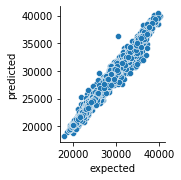

In [17]:
from sklearn import linear_model
def run_multiregression(train_features, train_labels, test_features, test_labels):
    regr = linear_model.LinearRegression()
    regr.fit(train_features, train_labels)
    
    reg_predictions = pd.DataFrame()
    reg_predictions[['expected']] = test_labels
    reg_predictions[['predicted']] = regr.predict(test_features)
    reg_predictions
    mse = get_mean_squared_error(reg_predictions.predicted.to_numpy(), reg_predictions.expected.to_numpy())
    print(f'Linear Regression\nMSE: {mse:5.3f}')
    sns.pairplot(data=reg_predictions, y_vars=['predicted'], x_vars=['expected'])

run_multiregression(train_features, train_labels, test_features, test_labels)

# Regression Neural Network


Neural Network
MSE: 380.924
            Name  MSE Without it
1   current_load     4818.694421
9          diff2     2264.568891
3          load3     1640.380913
4          load5     1399.996898
10         diff3      882.105605
5          load8      663.666898
11         diff5      619.929508
12         diff8      556.868174
2          load2      519.644969
0      real_hour      502.813266
6         load13      461.118665
7         load24      452.104611
13        diff13      401.944051
8         load37      388.509315


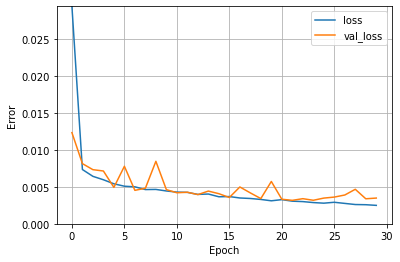

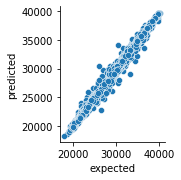

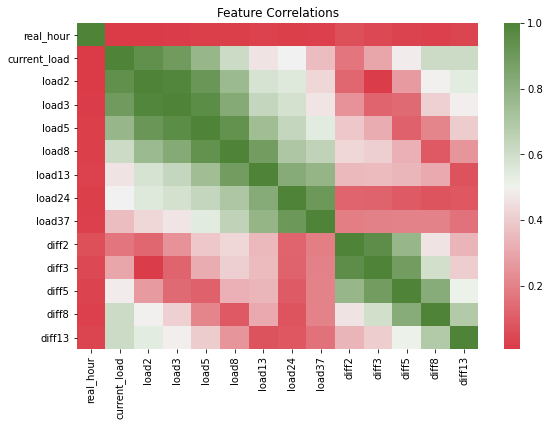

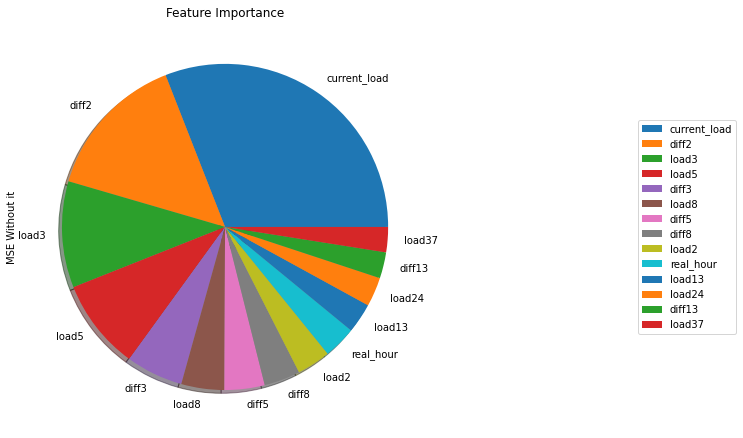

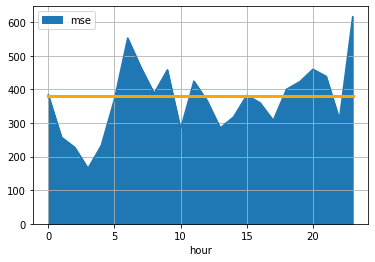

In [18]:
# Create the model.
FEATURE_COUNT = len(test_features.columns)

model = keras.Sequential()
model.add(keras.layers.Dense(60, activation='relu', input_shape=(FEATURE_COUNT,)))
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(
    loss='mean_squared_error',        
    optimizer=tf.keras.optimizers.Adam(0.001)
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=8)

history = model.fit(
    scaled_features, scaled_labels,
    batch_size=30,
    validation_split=0.2,
    shuffle=True, 
    verbose=0, epochs=100, callbacks=[early_stop])

x_test = feature_scaler.scale(test_features)
reg_predictions = pd.DataFrame(label_scaler.inverse(model.predict(x_test)))
reg_predictions[['expected']] = test_labels.load.values
reg_predictions[['date_time']] = test_date_time.date_time.values

reg_predictions.columns = ["predicted", 'expected', 'date_time']

mse = get_mean_squared_error(reg_predictions.predicted.to_numpy(), reg_predictions.expected.to_numpy())

plot_history(history)
mse = get_mean_squared_error(reg_predictions.predicted.to_numpy(), reg_predictions.expected.to_numpy())
print(f'Neural Network\nMSE: {mse:5.3f}')
_ = sns.pairplot(data=reg_predictions, y_vars=['predicted'], x_vars=['expected'])
utils.save_to_db(reg_predictions, 'reg_predictions')
x_test.columns = test_features.columns[:]
utils.feature_importance(model, features=x_test, scaler=label_scaler, labels=test_labels, date_times=test_date_time)


# Find regression prediction errors per hour
def get_generic_mean_squared_error():
    sql = f"""Select expected as actual, predicted as predicted from reg_predictions"""
    data = pd.read_sql_query(sql, con=engine)
    return np.sqrt(mean_squared_error(data['actual'], data['predicted']))

def get_mean_squared_error_per_hour(hour):
    sql = f"""
        Select expected as actual, predicted as predicted from reg_predictions
        where extract(hour from date_time) = {hour}
    """
    data = pd.read_sql_query(sql, con=engine)
    return np.sqrt(mean_squared_error(data['actual'], data['predicted']))

gmse = get_generic_mean_squared_error()
data = []
for hour in range(0, 24):
    data.append([hour, get_mean_squared_error_per_hour(hour), gmse])

df = pd.DataFrame(data, columns = ['hour', 'mse', 'gmse'])
df.plot.area(x="hour", y="mse", rot=0, grid=True)
_ = plt.plot(df['hour'], df['gmse'], color='orange', linewidth=3)    


In [63]:

def pair_feature_importance(the_model, features, scaler, labels, date_times):    
    feature_importances = []
    cols = list(features.columns)
    for i in range(len(cols)):
        original_f_1 = features[cols[i]].copy()
        features[cols[i]] = features[cols[i]].sample(frac=1).values
        for j in range(i+1, len(cols)):
            original_f_2 = features[cols[j]].copy()
            features[cols[j]] = features[cols[j]].sample(frac=1).values
            reg_predictions = pd.DataFrame(scaler.inverse(the_model.predict(features)))
            reg_predictions[['expected']] = labels.load.values
            reg_predictions[['date_time']] = date_times.date_time.values
            reg_predictions.columns = ["predicted", 'expected', 'date_time']
            mse = get_mean_squared_error(reg_predictions.predicted.to_numpy(), reg_predictions.expected.to_numpy())
            feature_importances.append((cols[i], cols[j], mse)) 
            features[cols[j]] = original_f_2
        features[cols[i]] = original_f_1
    return feature_importances

feature_importance_pairs =  pair_feature_importance(model, features=x_test, scaler=label_scaler, labels=test_labels, date_times=test_date_time)

NameError: name 'features' is not defined

In [64]:
sorted(feature_importance_pairs, key=lambda x: x[2], reverse=True)

[('current_load', 'load3', 5861.35256144381),
 ('current_load', 'diff2', 5769.551071626771),
 ('current_load', 'load5', 5302.247235344145),
 ('current_load', 'diff8', 5271.835663285661),
 ('current_load', 'diff13', 5197.81583568402),
 ('current_load', 'diff3', 5173.191322246367),
 ('current_load', 'load13', 5148.688065516441),
 ('price_day_ahead', 'current_load', 5131.452424591055),
 ('current_load', 'diff24', 5117.937046306684),
 ('current_load', 'diff37', 5114.90190835636),
 ('current_load', 'load24', 5105.189621284168),
 ('current_load', 'load37', 5093.610245856422),
 ('real_hour', 'current_load', 5091.88678204116),
 ('current_load', 'load8', 5082.9154577689005),
 ('current_load', 'diff5', 5024.844805816083),
 ('current_load', 'load2', 4661.973127261977),
 ('load3', 'diff2', 2888.828852800751),
 ('diff2', 'diff3', 2768.96858216),
 ('load5', 'diff2', 2429.008449733579),
 ('real_hour', 'diff2', 2420.2573481623713),
 ('load37', 'diff2', 2393.5585594953063),
 ('price_day_ahead', 'diff2'

In [33]:
len(feature_importance_pairs)

136

# Classifier

In [66]:
sql = """
select
    a.date_time,
    a.hour,
    a.load as current_load,
    median_diff_per_hour,
    a.diff1,
    a.diff2,
    a.diff3,
    a.diff5,
    a.diff8,
    a.diff13,
    a.diff24,
    a.diff37,
    a.median_diff,
    a.median_std
from
    ensemble_data a, diff_per_hour b
where
    b.hour = extract(hour from a.date_time)  and
    train = {train_flag} and {where_clause}

""".format

data1 = pd.read_sql_query(sql(where_clause="data_diff >= 0", train_flag=1), con=engine)
data1['target'] = data1.apply(lambda row: 1, axis=1)
data1 = data1.sample(frac=1.0)

data2  = pd.read_sql_query(sql(where_clause="data_diff < 0", train_flag=1), con=engine)
data2 = data2.sample(frac=1.0)

data2['target'] = data2.apply(lambda row: 0, axis=1)

print(len(data2), len(data1))

if len(data1) < len(data2):
    data2 = data2[0:len(data1)]
else:
    data1 = data1[0:len(data2)]
print(len(data2), len(data1))
        
train_dataset = pd.concat([data1, data2])

train_dataset = train_dataset.sample(frac=1.0)
train_dataset.pop('date_time')

# Get Testing data.

data1 = pd.read_sql_query(sql(where_clause="data_diff >= 0", train_flag=0), con=engine)
data1['target'] = data1.apply(lambda row: 1, axis=1)

data2 = pd.read_sql_query(sql(where_clause="data_diff < 0", train_flag=0), con=engine)
data2['target'] = data2.apply(lambda row: 0, axis=1)

test_dataset = pd.concat([data1, data2])
test_dataset = test_dataset.sort_values(by ='date_time' )
test_dataset.pop('date_time')

train_features = train_dataset.copy()
train_labels = pd.DataFrame(train_features.pop('target'))

test_features = test_dataset.copy()
test_labels = pd.DataFrame(test_features.pop('target'))

columns = train_features.columns
feature_scaler = Scaler(train_features, 'RobustScaler')
scaled_features = feature_scaler.scale(train_features)
scaled_features.columns = columns

scaled_test_features = feature_scaler.scale(test_features)



14018 10961
10961 10961


194/194 [==============================] - 0s 660us/step - loss: 0.1214 - accuracy: 0.9508
[0.12144356966018677, 0.9508090615272522]


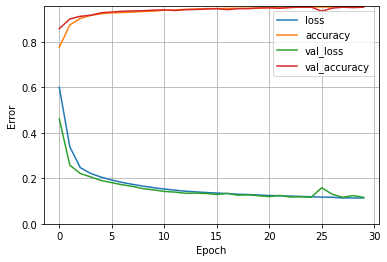

In [67]:
import tensorflow.keras as keras
from tensorflow.keras import layers

NUMBER_OF_FEATURES = len(train_features.columns)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)

callbacks=[early_stop]

model = keras.Sequential()
model.add(layers.Dense(130, activation='relu', input_shape=(NUMBER_OF_FEATURES,)))
model.add(keras.layers.Dense(130, activation='relu'))
model.add(keras.layers.Dense(130, activation='relu'))
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                   
history = model.fit(scaled_features, train_labels,epochs=30, batch_size=80, shuffle=True, verbose=0
                    , callbacks=[early_stop], validation_split=0.2)
score = model.evaluate(scaled_test_features, test_labels,verbose=1)
print(score)
plot_history(history)

Text(0, 0.5, 'success rate')

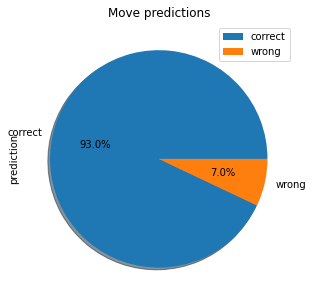

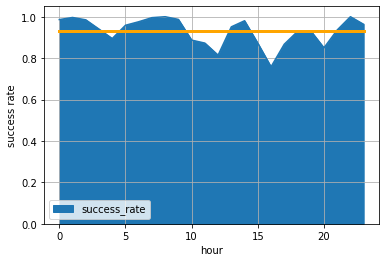

In [68]:
scaled_features = feature_scaler.scale(test_features)
class_predictions = pd.DataFrame(model.predict(scaled_features))
class_predictions
class_predictions.columns = ['percentage']
class_predictions['predicted'] = class_predictions.apply(lambda row: 1 if row.percentage > 0.5 else 0, axis=1)
class_predictions.pop('percentage')

reg_predictions['up_down'] = class_predictions.predicted.values
reg_predictions['median_std'] = test_features.median_std.values
reg_predictions['current_load'] = test_features.current_load.values

reg_predictions['diff'] = reg_predictions.apply(lambda row: row.expected - row.current_load, axis=1)

reg_predictions['t_flag1'] = reg_predictions.apply(lambda row: 1 if (row.up_down == 1) and (row.current_load < row.expected) else 0, axis=1)
reg_predictions['t_flag0'] = reg_predictions.apply(lambda row: 1 if (row.up_down == 0) and (row.current_load > row.expected) else 0, axis=1)
reg_predictions['f1'] = reg_predictions.apply(lambda row: 1 if row.predicted > row.current_load else 0, axis=1)
reg_predictions["diff"] = reg_predictions.apply(lambda row: 1 if row.predicted - row.expected >= 0 else 0, axis=1)
utils.save_to_db(reg_predictions, 'reg_predictions')
sql = """select pred as value, count(*) as prediction  from (select abs(up_down - f1) as pred from reg_predictions) s group by pred;"""
preds = pd.read_sql_query(sql, con=engine)
labels = ['correct', 'wrong']
_ = preds.plot.pie(y='prediction', figsize=(5, 5), title="Move predictions", labels=labels, autopct='%1.1f%%',shadow=True,)


def get_rate(hour=None):
    if hour is None:
        sql = f"""select pred as value, count(*) as prediction  from (select abs(up_down - f1) as pred from reg_predictions) s group by pred;"""
    else:
        sql = f"""select pred as value, count(*) as prediction  from (select abs(up_down - f1) as pred from reg_predictions where extract(hour from date_time) = {hour}  ) s group by pred;"""
    preds = pd.read_sql_query(sql, con=engine)
    correct = int(preds.query('value == 0').prediction)
    try:
        wrong = int(preds.query('value == 1').prediction)
    except Exception as ex:
        wrong = 0
    return correct / (wrong + correct)
generic_rate = get_rate()
data = []
for hour in range(0, 24):
    data.append([hour, get_rate(hour), generic_rate])
df = pd.DataFrame(data, columns = ['hour', 'success_rate', 'generic_rate'])
df.plot.area(x="hour", y="success_rate", rot=0, grid=True)
plt.plot(df['hour'], df['generic_rate'], color='orange', linewidth=3)
plt.ylabel('success rate')




In [ ]:
sql = """Select date_time as time, expected as observed_load, predicted as predicted_load, expected - predicted as diff, abs(100* (expected - predicted)/ expected) as percent_diff, up_down as expected_move from reg_predictions"""
summary = pd.read_sql_query(sql, con=engine)
_ = summary['percent_diff'].plot()